# CIS6800: Final Project Option 1: fine-tune SAM

### Overview:

Segment Anything Model (SAM) https://segment-anything.com/ was really cool on the surface, but you may hate SAM when you actually do research with it. Imagine you are trying to deploy a robot with SAM, but SAM runs 1 sec per 1 image. SAM use ViT backbone and 1024x1024 image as input, the computation cost is 4^4 = 256 times more intense than 224x224 input. Changing ViT input resolution requires fine-tuning. In this project, you will try to fine-tune a low-resolution SAM.

For data, you will use 10k images from SA-1B dataset https://ai.meta.com/datasets/segment-anything/. There will be a mIoU benchmark score, it will evaluate how your model replicate original SAM output down-scaled. The baseline model will be unfreeze the entire SAM, you will try to use LoRA https://arxiv.org/abs/2106.09685 to improve the score.

You will start with a already implemented SAM model as in official repo https://github.com/facebookresearch/segment-anything/tree/main, you will implement the training, evaluation, and modification such as LoRA.

## SAM Introduction

SAM is an interactive segmentation tool. To help understand SAM, first check our their demo https://segment-anything.com/demo#, official github repo https://github.com/facebookresearch/segment-anything/tree/main, code example https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb,

It is highly encouraged for you to review the SAM paper https://arxiv.org/pdf/2304.02643.pdf. However, the main text is filled with marketing stuff, the Appendix is more about implementation details.

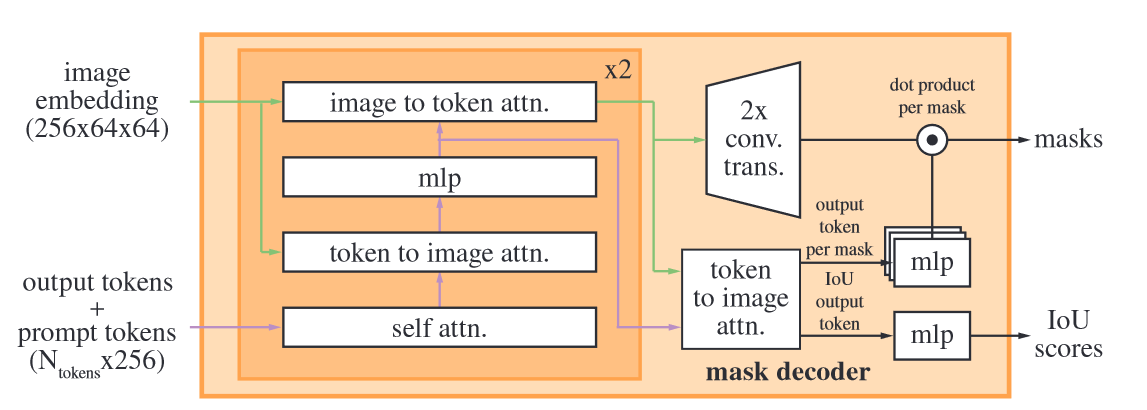

## Data
We provide you with 10k down-sampled images from SA-1B dataset https://ai.meta.com/datasets/segment-anything/



The following code downloads the original dataset, processes it, and visualizes an example.

In [1]:
# manual download: https://drive.google.com/file/d/1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm/view?usp=sharing

!gdown --id 1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm
!unzip -o -q sa1b.zip

'gdown' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [3]:
!unzip -o -q sa1b.zip

'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [2]:
!pip install pytorch-lightning pycocotools

In [47]:
%load_ext autoreload
%autoreload 2
import glob
import os
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

from pycocotools import mask as mask_utils

import json
import numpy as np
from tqdm import tqdm

# new_height, new_width  = 160, 256
new_height, new_width  = 256, 256
input_transforms = transforms.Compose([
    transforms.Resize((new_height, new_width)),
    transforms.ToTensor(),
])

target_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((new_height, new_width)),
])

def resize_bbox(bbox, original_width, original_height, new_width=256, new_height=160):
    """
    Resize bounding box coordinates based on the new image dimensions.

    Args:
        bbox (list or tuple): The original bounding box [x, y, width, height].
        original_width (int or float): The original width of the image.
        original_height (int or float): The original height of the image.
        new_width (int or float): The new width to resize the image to.
        new_height (int or float): The new height to resize the image to.

    Returns:
        list: The resized bounding box [new_x, new_y, new_width, new_height].
    """
    # Calculate scaling factors for width and height
    scale_x = new_width / original_width
    scale_y = new_height / original_height

    # Unpack the original bounding box
    x, y, w, h = bbox

    # Apply scaling factors to each component of the bounding box
    new_x = x * scale_x
    new_y = y * scale_y
    new_w = w * scale_x
    new_h = h * scale_y

    return [new_x, new_y, new_w, new_h]



class SA1B_Dataset(torchvision.datasets.ImageFolder):
    """A data loader for the SA-1B Dataset from "Segment Anything" (SAM)
    This class inherits from :class:`~torchvision.datasets.ImageFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.imgs[index] # discard automatic subfolder labels
        image = self.loader(path)
        masks = json.load(open(f'{path[:-3]}json'))['annotations'] # load json masks
        # print(json.load(open(f'{path[:-3]}json')))
        seg = []
        bbox = []

        for m in masks:
            # decode masks from COCO RLE format
            seg_piece = mask_utils.decode(m['segmentation'])
            original_height, original_width = seg_piece.shape
            seg.append(seg_piece)
            bbox.append(resize_bbox(m['bbox'], original_width, original_height, new_width=new_width, new_height=new_height))
            
        seg = np.stack(seg, axis=-1)
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            seg = self.target_transform(seg)
        seg[seg > 0] = 1 # convert to binary masks

        return image, torch.tensor(bbox), torch.tensor(seg).long() 
        

    def __len__(self):
        return len(self.imgs)


input_reverse_transforms = transforms.Compose([
    transforms.ToPILImage(),
])

import matplotlib.pyplot as plt
def show_image(image, bbox, masks, num_rows=12, num_cols=12):
    # image: numpy image
    # target: mask [N, H, W]
    # fig, axs = plt.subplots(row, col, figsize=(20, 12))
    # for i in range(row):
    #     for j in range(col):
    #         if i*row+j < target.shape[0]:
    #             axs[i, j].imshow(image)
    #             axs[i, j].imshow(target[i*row+j], alpha=0.5)
    #         else:
    #             axs[i, j].imshow(image)
    #         axs[i, j].axis('off')

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))
    total = num_rows * num_cols
    
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            ax = axs[i, j]
            if idx < masks.shape[0]:
                ax.imshow(image)
                ax.imshow(masks[idx], alpha=0.5, cmap='jet')  # Use a colormap for better visibility
                # Draw bounding box
                box = bbox[idx].numpy()
                rect = plt.Rectangle((box[0], box[1]), box[2], box[3],
                                     linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            else:
                ax.imshow(image)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\ALAN\AppData\Local\Temp\ipykernel_20808\1176675254.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(bbox), torch.tensor(seg).long()


torch.Size([3, 256, 256]) torch.Size([45, 256, 256])
Epoch 0:   0%|                                                                              | 0/1119 [3:09:14<?, ?it/s]


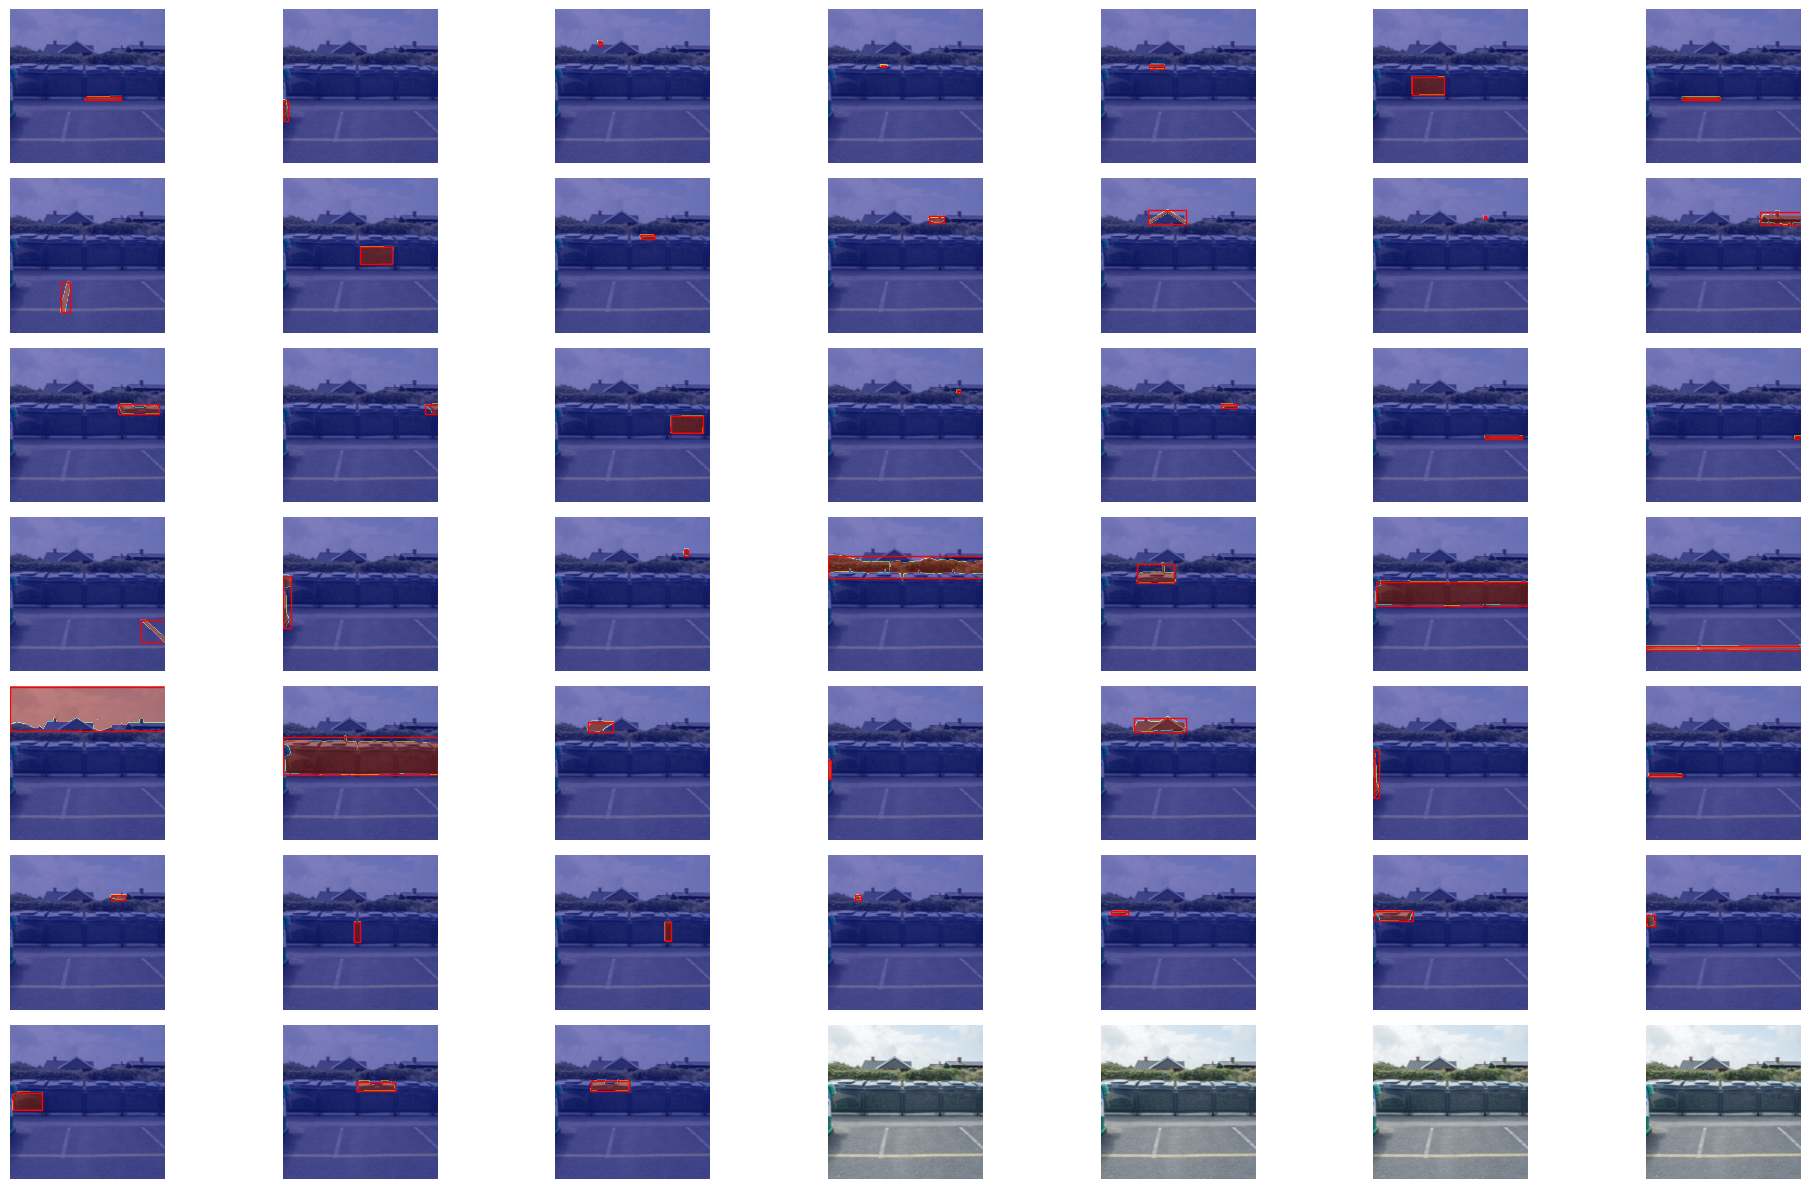

In [48]:
path = './sa1b'
dataset = SA1B_Dataset(path, transform=input_transforms, target_transform=target_transforms)
image, bbox, masks = dataset.__getitem__(3535)
print(image.shape, masks.shape)
image = input_reverse_transforms(image)
image = np.array(image)
show_image(image, bbox, masks, num_rows=7, num_cols=7)

## SAM model
You will start from offical SAM implementation, the heavy part is already implementated, but you have to make modification to the model, it's critical to read their code and know how things work. You will need to read through SAM's code starting from https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/modeling/image_encoder.py

For SAM: See Appendix A https://arxiv.org/pdf/2304.02643.pdf

In [4]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
# you may want to make a local copy instead of pip install,
# as you may need to modify their code
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\alan\appdata\local\temp\pip-req-build-7vt5ppgq


  ERROR: Error [WinError 2] 系统找不到指定的文件。 while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [49]:
from finetune import *

In [50]:
from torch.utils.data import random_split
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for each set
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")

# Set a manual seed for reproducibility
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")


Total samples: 11186
Training samples: 8948
Validation samples: 2238
Training dataset length: 8948
Validation dataset length: 2238


In [51]:
NUM_WORKERS = 0  # https://github.com/pytorch/pytorch/issues/42518
NUM_GPUS = torch.cuda.device_count()
DEVICE = 'cuda'
print(NUM_WORKERS, NUM_GPUS, DEVICE)

0 1 cuda


In [52]:
from types import SimpleNamespace

def dict_to_namespace(d):
    return SimpleNamespace(**d)

config_dict = {
    "model_type": "vit_b",
    "checkpoint_path": "sam_vit_b_01ec64.pth",
    "freeze_image_encoder": False,
    "freeze_prompt_encoder": False,
    "freeze_mask_decoder": False,
    "batch_size": 4,
    'original_img_size': 1024,
    'patch_size': 16,
    'new_img_size': (256, 256),
    "steps": 1500,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "metrics_interval": 50,
    "output_dir": 'project_checkpoints/'
}

args = dict_to_namespace(config_dict)

model = SAMFinetuner(
    args.model_type,
    args.checkpoint_path,
    freeze_image_encoder=args.freeze_image_encoder,
    freeze_prompt_encoder=args.freeze_prompt_encoder,
    freeze_mask_decoder=args.freeze_mask_decoder,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=args.batch_size,
    learning_rate=args.learning_rate,
    weight_decay=args.weight_decay,
    metrics_interval=args.metrics_interval,
    original_img_size = 1024,
    patch_size = 16,
    new_img_size = (256, 256)
)

callbacks = [
    LearningRateMonitor(logging_interval='epoch'),
    ModelCheckpoint(
        dirpath=args.output_dir,
        filename='{step}-{val_per_mask_iou:.2f}',
        save_last=True,
        save_top_k=10,
        monitor="val_per_mask_iou",
        mode="max",
        save_weights_only=True,
        every_n_train_steps=args.metrics_interval,
    ),
]
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger(save_dir='lightning_logs/', name='sam_finetuning')

trainer = pl.Trainer(
    strategy='ddp' if NUM_GPUS > 1 else 'auto',
    accelerator=DEVICE,
    devices=NUM_GPUS,
    precision=32,
    callbacks=callbacks,
    max_epochs=-1,
    max_steps=args.steps,
    val_check_interval=args.metrics_interval,
    check_val_every_n_epoch=None,
    num_sanity_val_steps=2,
    logger=logger
)

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode
--------------------------------------
0 | model | Sam  | 90.8 M | eval
--------------------------------------
90.8 M    Trainable params
0         Non-trainable params
90.8 M    Total params
363.145   Total estimated model params size (MB)
17        Modules in train mode
221       Modules in eval mode


Epoch 0:   0%|                                                                                | 0/1119 [00:00<?, ?it/s]

C:\Users\ALAN\AppData\Local\Temp\ipykernel_20808\1176675254.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(bbox), torch.tensor(seg).long()


Epoch 0:   4%| | 50/1119 [22:43<8:05:58,  0.04it/s, v_num=7, loss=1.710, loss_focal=0.00691, loss_dice=0.988, loss_iou=

C:\Users\ALAN\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:384: `ModelCheckpoint(monitor='val_per_mask_iou')` could not find the monitored key in the returned metrics: ['lr-AdamW', 'loss', 'loss_focal', 'loss_dice', 'loss_iou', 'train_per_mask_iou', 'epoch', 'step']. HINT: Did you call `log('val_per_mask_iou', value)` in the `LightningModule`?



Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   2%|█▏                                                     | 6/280 [02:26<1:51:50,  0.04it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [22]:
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")

In [12]:
# you need to inject LoRA to Linear(...), Conv2d(...), ConvTranspose2d(...)
print(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [42]:
sam.prompt_encoder

PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def interpolate_pos_embed(model, new_grid_size):
    """
    Interpolates the positional embeddings to a new grid size.
    
    Args:
        model (ImageEncoderViT): The image encoder model.
        new_grid_size (tuple): The new grid size as (new_H, new_W).
    
    Returns:
        nn.Parameter: The interpolated positional embeddings.
    """
    pos_embed = model.pos_embed  # Shape: (1, H, W, C)
    _, H, W, C = pos_embed.shape  # Original grid size, e.g., H=W=64 for 1024x1024
    
    new_H, new_W = new_grid_size  # e.g., (10, 16) for 160x256 with patch size 16
    
    # Permute to (1, C, H, W) for interpolation
    pos_embed = pos_embed.permute(0, 3, 1, 2)  # Shape: (1, C, H, W)
    
    # Interpolate to new grid size
    pos_embed = F.interpolate(pos_embed, size=(new_H, new_W), mode='bicubic', align_corners=False)
    
    # Permute back to (1, H, W, C)
    pos_embed = pos_embed.permute(0, 2, 3, 1)  # Shape: (1, new_H, new_W, C)
    
    # Convert to nn.Parameter
    pos_embed = nn.Parameter(pos_embed)
    
    return pos_embed


# Example usage:
# Assuming `sam` is your pretrained SAM model and `sam.image_encoder` is an instance of ImageEncoderViT

original_img_size = 1024
patch_size = 16
new_img_size = (160, 256)  # (height, width)
new_grid_size = (new_img_size[0] // patch_size, new_img_size[1] // patch_size)  # (10, 16)

# Interpolate pos_embed
sam.image_encoder.pos_embed = interpolate_pos_embed(sam.image_encoder, new_grid_size)

# Update the image encoder's img_size attribute
sam.image_encoder.img_size = new_img_size  # Update image size to (160, 256)



NameError: name 'sam' is not defined

In [21]:
print(sam.image_encoder.pos_embed.shape)  # Should output: torch.Size([1, 16, 16, 768])


torch.Size([1, 16, 16, 768])


In [24]:
sam.image_encoder.img_size = new_img_size  # Update the image size to 256



In [ ]:
class SAMFineTuner(pl.LightningModule):
    def __init__(self, 
                 sam_checkpoint: str, 
                 img_size: tuple = (160, 256), 
                 patch_size: int = 16, 
                 learning_rate: float = 1e-5):
        """
        Initializes the SAM fine-tuner.
        
        Args:
            sam_checkpoint (str): Path to the SAM checkpoint.
            img_size (tuple): New image size as (height, width).
            patch_size (int): Patch size used in the image encoder.
            learning_rate (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.save_hyperparameters()
        
        # Load the SAM model
        self.sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
        
        # Modify positional embeddings
        new_grid_size = (img_size[0] // patch_size, img_size[1] // patch_size)  # (10, 16)
        self.sam.image_encoder.pos_embed = interpolate_pos_embed(self.sam.image_encoder, new_grid_size)
        self.sam.image_encoder.img_size = img_size  # Update image size
        
        # Freeze image encoder layers if desired
        # Uncomment the following lines to freeze all but the last block
        # for name, param in self.sam.image_encoder.named_parameters():
        #     if "blocks.11" not in name and "neck" not in name:
        #         param.requires_grad = False
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()  # Suitable for binary masks
    
    def forward(self, images, masks=None):
        """
        Forward pass through SAM.
        
        Args:
            images (torch.Tensor): Input images of shape [B, 3, H, W].
            masks (torch.Tensor, optional): Ground truth masks of shape [B, N, H, W].
        
        Returns:
            logits (torch.Tensor): Predicted mask logits.
        """
        # Generate dummy prompts (e.g., no prompts)
        # SAM typically requires prompts like points, boxes, etc.
        # For simplicity, we'll use no prompts and let SAM predict masks globally
        
        # Forward pass through image encoder
        image_embeddings = self.sam.image_encoder(images)  # Shape: [B, C, H', W']
        
        # Initialize predictor
        predictor = SamPredictor(self.sam)
        predictor.set_image(images)
        
        # If no prompts, you can generate prompts or use default behavior
        # Here, we'll assume no prompts and let SAM generate masks
        # However, SAM's mask decoder typically requires prompts, so this is a simplification
        
        # To properly use SAM, you might need to generate prompts from masks, e.g., points within masks
        # For this example, we'll skip prompts and use a custom head
        
        # Alternatively, you can modify SAM to include a segmentation head that predicts masks directly
        # Here's a simple approach using a convolutional head
        logits = self.sam.image_encoder.neck(image_embeddings)  # Shape: [B, C, H', W']
        logits = torch.sigmoid(logits)  # Apply sigmoid for binary classification
        
        return logits
    
    def training_step(self, batch, batch_idx):
        images, masks = batch  # images: [B, 3, 160, 256], masks: [B, N, 160, 256]
        # For simplicity, we'll assume binary masks and average over masks
        # Alternatively, you can handle multiple masks per image
        
        # Flatten masks to single channel by taking the maximum across mask dimension
        masks = masks.max(dim=1)[0]  # Shape: [B, 160, 256]
        
        logits = self.forward(images)  # Shape: [B, C, H', W']
        
        # Resize logits to match mask size if necessary
        # Assuming neck output size matches mask size
        loss = self.criterion(logits.squeeze(1), masks)  # Shape: [B, 160, 256]
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        masks = masks.max(dim=1)[0]
        
        logits = self.forward(images)
        loss = self.criterion(logits.squeeze(1), masks)
        
        # Compute additional metrics, e.g., IoU
        preds = torch.sigmoid(logits).squeeze(1) > 0.5
        intersection = (preds & masks.byte()).float().sum((1, 2))
        union = (preds | masks.byte()).float().sum((1, 2))
        iou = (intersection / (union + 1e-6)).mean()
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]


In [35]:
dataset[5][1].shape

torch.Size([83, 160, 256])

## Results (in your report)
1. show the output of original sam model (not fine-tuned) bullied to low-resolution, compare to the original sam at high-resolution (upscale the low-resolution image back to 1600x2560).

Hint: Example code from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb will always rescale the input to 1024x1024 before passing to sam encoder, you need to modify and bypass SamPredictor's code to pass low-resolution input. In particular, wrong shape of positional encoding will raise error on every attention layer, you will need to either 1) downsample existing PE in every layer or 2) re-initilize PE to the low-resolution shape

2. disccuss the difficulty in applying sam to low resolution input. why fine-tuning is needed, what's the alternative solution.

Hint: start from positional encoding, patchfy operation, first convolution layer, are they scale invariant? why and why not.



## LoRA module
We also provide you an toy example of LoRA module injected into any nn.Linear class. You will implement similar LoRA class for Conv2D and ConvTranspose2d.

For LoRA: https://arxiv.org/abs/2106.09685

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.9 MB/s eta 0:00:00


In [ ]:
from torch import nn

In [ ]:
class LoRALinearLayer(nn.Module):
    def __init__(self, in_features, out_features, rank=4):
        super().__init__()

        if rank > min(in_features, out_features):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(in_features, out_features)}"
            )

        self.down = nn.Linear(in_features, rank, bias=False)
        self.up = nn.Linear(rank, out_features, bias=False)

        nn.init.normal_(self.down.weight, std=1 / rank)
        nn.init.zeros_(self.up.weight)

    def forward(self, hidden_states):
        orig_dtype = hidden_states.dtype
        dtype = self.down.weight.dtype

        down_hidden_states = self.down(hidden_states.to(dtype))
        up_hidden_states = self.up(down_hidden_states)

        return up_hidden_states.to(orig_dtype)

    @property
    def weight(self):
        return self.up.weight @ self.down.weight

    @property
    def bias(self):
        return 0

class MonkeyPatchLoRALinear(nn.Module):
    # It's "monkey patch" means you can replace nn.Linear with the new
    # LoRA Linear class without modifying any other code.
    def __init__(self, fc: nn.Linear, rank=4, lora_scale=1):
        super().__init__()
        if rank > min(fc.in_features, fc.out_features):
            raise ValueError(
                f"LoRA rank {rank} must be less or equal than {min(fc.in_features, fc.out_features)}"
            )
        if not isinstance(fc, nn.Linear):
            raise ValueError(
                f"MonkeyPatchLoRALinear only support nn.Linear, but got {type(fc)}"
            )

        self.fc = fc
        self.rank = rank
        self.lora_scale = lora_scale

        in_features = fc.in_features
        out_features = fc.out_features
        self.fc_lora = LoRALinearLayer(in_features, out_features, rank)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc(hidden_states) + \
                        self.lora_scale * self.fc_lora(hidden_states)
        return hidden_states

    @property
    def weight(self):
        return self.fc.weight + self.lora_scale * self.fc_lora.weight

    @property
    def bias(self):
        return self.fc.bias

# your implementation

class LoRAConv2DLayer(nn.Module):
    ...

class MonkeyPatchLoRAConv2D(nn.Module):
    ...

class LoRAConvTranspose2DLayer(nn.Module):
    ...

class MonkeyPatchLoRAConvTranspose2D(nn.Module):
    ...

In [ ]:
# MLP toy example of LoRA

from timm.layers.mlp import Mlp

mlp = Mlp(768)
print(mlp)

def freeze(module):
    from pytorch_lightning.callbacks.finetuning import BaseFinetuning

    BaseFinetuning.freeze(module, train_bn=True)

freeze(mlp)

Mlp(
  (fc1): Linear(in_features=768, out_features=768, bias=True)
  (act): GELU(approximate='none')
  (drop1): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (fc2): Linear(in_features=768, out_features=768, bias=True)
  (drop2): Dropout(p=0.0, inplace=False)
)


In [ ]:
def print_params(model):
  model_parameters = filter(lambda p: True, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("total params: ", params)
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("training params: ", params)

In [ ]:
print_params(mlp)

total params:  1181184
training params:  0


In [ ]:
# inject LoRA

for name, block in mlp.named_children():
    # patch every nn.Linear in Mlp
    if isinstance(block, nn.Linear):
      block = MonkeyPatchLoRALinear(block, 4, 1)
      setattr(mlp, name, block)

In [ ]:
print(mlp)

Mlp(
  (fc1): MonkeyPatchLoRALinear(
    (fc): Linear(in_features=768, out_features=768, bias=True)
    (fc_lora): LoRALinearLayer(
      (down): Linear(in_features=768, out_features=4, bias=False)
      (up): Linear(in_features=4, out_features=768, bias=False)
    )
  )
  (act): GELU(approximate='none')
  (drop1): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (fc2): MonkeyPatchLoRALinear(
    (fc): Linear(in_features=768, out_features=768, bias=True)
    (fc_lora): LoRALinearLayer(
      (down): Linear(in_features=768, out_features=4, bias=False)
      (up): Linear(in_features=4, out_features=768, bias=False)
    )
  )
  (drop2): Dropout(p=0.0, inplace=False)
)


In [ ]:
print(mlp.fc1.fc.weight.requires_grad) # load this from trained model, freeze
print(mlp.fc1.fc_lora.weight.requires_grad) # LoRA initilized, do not freeze

False
True


In [ ]:
print_params(mlp)

total params:  1193472
training params:  12288


## Methods and Results (in your report)

1. how do you implement LoRA, which part of SAM model do you fine-tune?
2. summarize number of parameters before and after LoRA
3. compare training results of completely unfreeze SAM v.s. LoRA.

## SAM target assignment

Take a closer look at the data, there's some big mask containing small masks. the SAM model will predict 3 output masks (with 3 confidence score) for a single prompt, 3 mask outputs is ordered from big to small objects. You will need to implement function to sample these 3 masks from masks of one image in SA-1B dataset.

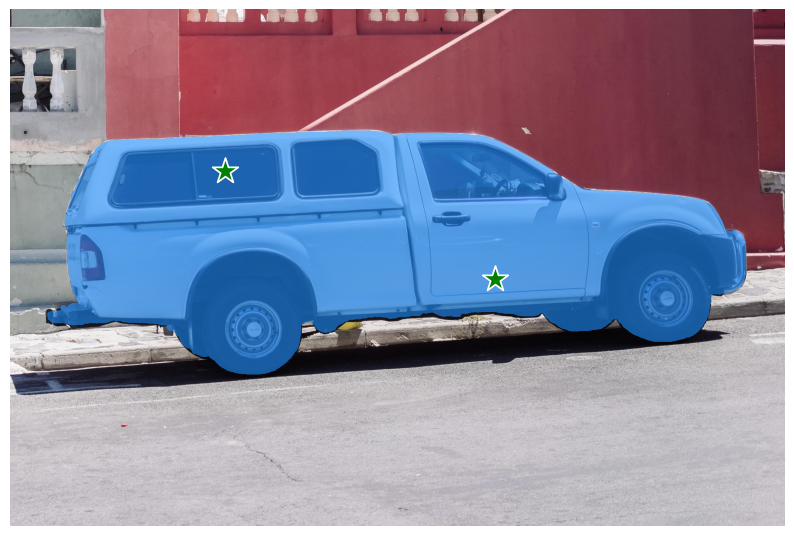

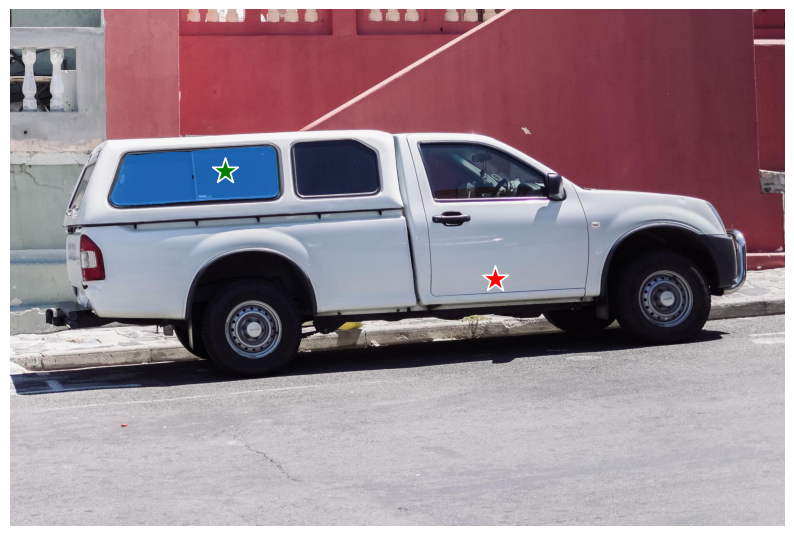

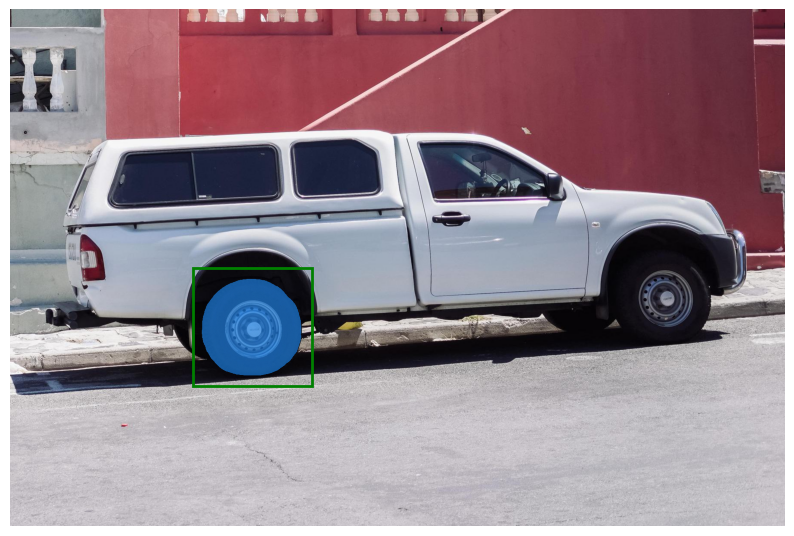

In [ ]:
def point_sample(all_masks, points_coords, points_label):
    # all_masks: [N, H, W], one image, N masks
    # points_coords: (N, 2)
    # points_label: (N, 1), 1 for foreground, 0 for background
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function
    ...

def box_sample(all_masks, bbox):
    # all_masks: [N, H, W], one image, N masks
    # bbox: (xxyy)
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function
    ...

# you don't need to implement the case with both points and box

## Visulize (in your report)

show the returned 3 masks, ordered from big to small

show `point_sample()` with 1. one positive point, 2. one positive and one negative point. 3. multiple points with both positive and negative

show `box_sample()` with 1. one positive box

## Training
as described in SAM paper Section 3 and Appendix A. You simulate an interactive segmentation setup during training: you need to implement 1a. single point prompt training 1b. iterative training up to 3 iteration 2. box prompt training, only 1 iteration;

### 1a and 2: one iteration training
First, with equal probability either a foreground point
or bounding box is selected randomly for the target mask.
Points are sampled uniformly from the ground truth mask.
Boxes are taken as the ground truth mask’s bounding box,
with random noise added in each coordinate with standard
deviation equal to 10% of the box sidelength, to a maximum of 20 pixels.

### 1b: three iteration training
After making a prediction from this first prompt, subsequent points are selected uniformly from the error region
between the previous mask prediction and the ground truth
mask. Each new point is foreground or background if the error region is a false negative or false positive, respectively.
We also supply the mask prediction from the previous iteration as an additional prompt to our model. To provide
the next iteration with maximal information, we supply the
unthresholded mask logits instead of the binarized mask.
When multiple masks are returned, the mask passed to the
next iteration and used to sample the next point is the one
with the highest predicted IoU.

- You do not need to implement text prompt as there's no text data in SA-1B dataset

In [ ]:
from segment_anything.modeling.sam import Sam
import pytorch_lightning as pl


class MyFastSAM(pl.LightningModule):
    def __init__(self, orig_sam: Sam, lora_rank: int, lora_scale: float):
        super().__init__()
        self.lora_sam = ...

    def forward(self, *args, **kwargs):
        """
        comments imported from original SAM code

        Arguments:
          batched_input (list(dict)): A list over input images, each a
            dictionary with the following keys. A prompt key can be
            excluded if it is not present.
              'image': The image as a torch tensor in 3xHxW format,
                already transformed for input to the model.
              'original_size': (tuple(int, int)) The original size of
                the image before transformation, as (H, W).
              'point_coords': (torch.Tensor) Batched point prompts for
                this image, with shape BxNx2. Already transformed to the
                input frame of the model.
              'point_labels': (torch.Tensor) Batched labels for point prompts,
                with shape BxN.
              'boxes': (torch.Tensor) Batched box inputs, with shape Bx4.
                Already transformed to the input frame of the model.
              'mask_inputs': (torch.Tensor) Batched mask inputs to the model,
                in the form Bx1xHxW.
          multimask_output (bool): Whether the model should predict multiple
            disambiguating masks, or return a single mask.

        Returns:
          (list(dict)): A list over input images, where each element is
            as dictionary with the following keys.
              'masks': (torch.Tensor) Batched binary mask predictions,
                with shape BxCxHxW, where B is the number of input prompts,
                C is determined by multimask_output, and (H, W) is the
                original size of the image.
              'iou_predictions': (torch.Tensor) The model's predictions
                of mask quality, in shape BxC.
              'low_res_logits': (torch.Tensor) Low resolution logits with
                shape BxCxHxW, where H=W=256. Can be passed as mask input
                to subsequent iterations of prediction.
        """
        return self.lora_sam(...)

    def configure_optimizers(self):
        lora_parameters = [param for param in self.parameters() if param.requires_grad]
        # make sure original sam don't requires_grad
        optimizer = torch.optim.AdamW(lora_parameters, lr=1e-5)
        return optimizer

    @staticmethod
    def mask_dice_loss(prediction, targets):
        ...

    @staticmethod
    def mask_focal_loss(prediction, targets):
        ...

    @staticmethod
    def iou_token_loss(iou_prediction, prediction, targets):
        ...

    def training_step(self, batch, batch_idx):
        images, targets = batch
        batched_input = self.construct_batched_input(...)
        # 1a. single point prompt training
        # 1b. iterative point prompt training up to 3 iteration
        # 2. box prompt training, only 1 iteration
        predictions = self.forward(batched_input)
        loss = ...
        self.log('train_loss', loss, prog_bar=True)
        # During training, we backprop only the minimum loss over the 3 output masks.
        # sam paper main text Section 3
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        ...
        loss = ...
        # use same procedure as training, monitor the loss
        self.log('val_loss', loss, prog_bar=True)

## Results (in your report)

1. show the process of sampling points in multiple iteration training, how the GT mask is assigned in each iteration
1. show training / validation loss curve, for each loss and sum of all losses.
1. besides loss, think about metrics such as mIoU, mAP, how to implement them in the sam's setting, or why not to implement each metrics, what make them unsuitable for sam's task? Remember: 1) we only have masks without category 2) sam need prompts.
1. on your trained model, cherry pick good examples, but also pick bad examples, rescale the input image back to 1024x1024 pixels, pass them to the original SAM model with the original pipeline, compare to your low-resolution LoRA results, disccuss what make them good or bad.